# Network Analysis

In the context of analyzing the impact of an actor's popularity on movie ratings, network analysis allows us to look at the connections between actors and how they may influence each other's contribution to the ratings. By visualizing the relationships between actors as a network, we can identify patterns and communities within the movie industry, and gain a more nuanced understanding of the ways in which actors' popularity contribute to ratings. 

Overall, incorporating network analysis into our analysis of actor contributions to movie ratings can provide valuable insights and help us better understand the complex relationships within the data.

In [123]:
# Import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw
import networkx as nx
import community

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [124]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv') 
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

In [125]:
movies.isna().sum()

wikipedia_id                   0
freebase_id                    0
name                           0
release_date                   0
revenue                    21460
runtime                        0
languages                      0
countries                      0
genres                         0
year_release                   0
averageRating                  0
numVotes                       0
average_award_cumcount      3702
average_movies_cumcount     3702
award_cumcount              3702
movies_cumcount             3702
dtype: int64

In [126]:
actors_list.isna().sum()

name        1
awards      0
movies      1
Fame        0
Liked       0
Disliked    0
Neutral     0
dtype: int64

Note (!)  null values for 1 in name, movies and below 1 in id, name, movies

In [127]:
actors_info.isna().sum()

actor_birth           76097
actor_gender          37800
actor_height         121294
actor_etnicity       125974
actor_name                1
freebase_actor_id         1
awards                    0
movies                    1
Fame                      0
Liked                     0
Disliked                  0
Neutral                   0
dtype: int64

In [128]:
characters.isna().sum()

wikipedia_movie_id                 0
freebase_movie_id                  0
movie_release_date                 0
character_name                 90614
actor_birth                    37774
actor_gender                   16299
actor_height                  107893
actor_etnicity                134592
actor_name                       149
actor_age_at_release           56626
freebase_char_actor_map_id         0
freebase_character_id          90610
freebase_actor_id                  0
Fame                               0
Liked                              0
Disliked                           0
Neutral                            0
award_cumcount                     0
movies_cumcount                    0
dtype: int64

The character dataset does not contain any missing freebase_actor_id or freebase_movie_id, therefore no entries have to be removed. 

In [129]:
# Removing actors without movie information
actors_list = actors_list[actors_list['movies'].notna()]
actors_info = actors_info[actors_info['movies'].notna()]

One actor had missing name, id and movie information. The actor was removed from the working dataframes.

In [130]:
# Removing movies from before 2000
movies = movies[movies['year_release'] >= 2000] 

# Rename movies' column 
movies = movies.rename(columns={'freebase_id': 'freebase_movie_id'}) 

# Merging movies with characters on freebase_movie_id
# to get the actors' freebase_actor_id
movies_characters = pd.merge(
    left=movies,
    right=characters,
    left_on="freebase_movie_id",  # Column from the "movies" DataFrame
    right_on="freebase_movie_id"  # Column from the "characters" DataFrame
)

# Filter out duplicates of 'freebase_movie_id' and 'freebase_actor_id'
movies_characters = movies_characters.drop_duplicates(
    subset=["freebase_movie_id", "freebase_actor_id"], keep="first"
)

## One Hot Encoding of Actors

In [131]:
# One Hot Encoding of Actors
actor_one_hot = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_id"]
)

# Only include wikipedia_id and one hot encoding of actors in dataframe
actor_one_hot = actor_one_hot.filter(
    regex="wikipedia_id|freebase_actor_id_"
)

actor_one_hot.shape

(61752, 35973)

Number of actors with more than 5 movie appearances: 1581
Number of actors with more than 10 movie appearances: 330
Number of actors with more than 12 movie appearances: 178
Number of actors with more than 15 movie appearances: 50


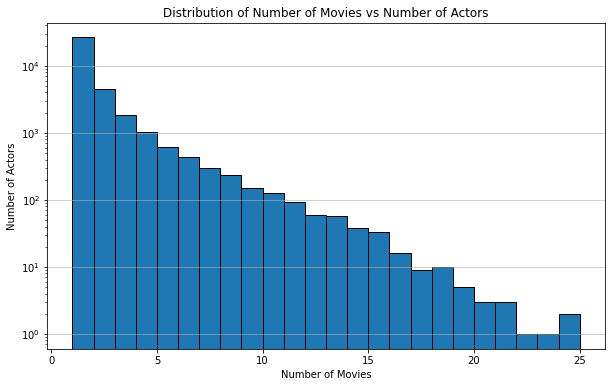

In [132]:
# Create subsets of actor one-hot encoding for different movie count thresholds
actor_one_hot_5 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 5]
actor_one_hot_10 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 10]
actor_one_hot_12 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 12]
actor_one_hot_15 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 15]

# Print the number of actors that have played in more than 5 and 10 movies
print("Number of actors with more than 5 movie appearances: {}".format(actor_one_hot_5.shape[1] - 1))
print("Number of actors with more than 10 movie appearances: {}".format(actor_one_hot_10.shape[1] - 1))
print("Number of actors with more than 12 movie appearances: {}".format(actor_one_hot_12.shape[1] - 1))
print("Number of actors with more than 15 movie appearances: {}".format(actor_one_hot_15.shape[1] - 1))

# Calculate the count of actors for each number of movie appearances
actors_per_movie_count = actor_one_hot.sum(axis=0)

# Remove the count of the "wikipedia_id" column
actors_per_movie_count = actors_per_movie_count.drop("wikipedia_id")

# Create a histrogram with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
plt.hist(actors_per_movie_count, bins=range(1, actors_per_movie_count.max() + 1), edgecolor='k')
plt.xlabel('Number of Movies')
plt.ylabel('Number of Actors')
plt.title('Distribution of Number of Movies vs Number of Actors')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.show()


We decided to restrict our dataframe to actors who worked in more than 15 movies. 

In [133]:
actor_one_hot_choice = actor_one_hot_15

In [134]:
# Grouping movies so that each movie corresponds to a single row in the dataframe
movies_grouped_by_actor = actor_one_hot_choice.groupby("wikipedia_id").agg("sum")

# Merging the dummy actor columns with the movie data
movies_actors_one_hot = pd.merge(
    movies, movies_grouped_by_actor, left_on="wikipedia_id", right_index=True
)

# Check the shape of the resulting dataframe
movies_actors_one_hot.shape

(6434, 66)

Missing all the genre, languages, countries, etc. 1-hot preprocessing

In [135]:
# Create an empty graph
G = nx.Graph()

# Initialize dictionaries to store actor ratings and movies
actor_ratings = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies = {}   # Dictionary to store the movies each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot dataframe
for _, row in movies_actors_one_hot.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings[actor][0] += rating  # Update total ratings for this actor
            actor_ratings[actor][1] += 1  # Update movie count for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # Update node size
            actor_movies[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # Update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # Add a new edge with weight 1  

# Update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # Number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

In [136]:
# Get the number of edges
num_nodes = G.number_of_nodes()
# Print the number of edges
print("The number of nodes in the graph G is:", num_nodes)

# Get the number of edges
num_edges = G.number_of_edges()
# Print the number of edges
print("The number of edges in the graph G is:", num_edges)

The number of nodes in the graph G is: 50
The number of edges in the graph G is: 178


In [137]:
def get_ab_from_actor(node, node_sizes, pos):
    # read the image file for this node
    img = Image.open('./img/' + node.split('/m/')[0] + node.split('_ID_')[1].replace('/', ':') + '.jpg')

    h,w = img.size
    # Resize the image to a square shape
    side_length = min(h, w)
    # crop the image to a square
    img = img.crop(((h-side_length)//2, (w-side_length)//2, (h+side_length)//2, (w+side_length)//2))
    img = img.resize((800,800))
    h,w = img.size
    
    # creating luminous image
    lum_img = Image.new('L',[h,w] ,0) 
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(0,0),(h,w)],0,360,fill=255)
    img_arr = np.array(img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr, lum_img_arr))

    image = Image.fromarray(final_img_arr)
    
    # create an OffsetImage object for the image
    image_offset = OffsetImage(image, zoom=node_sizes[node]/2000000000) 
    
    # create an AnnotationBbox object for the image
    ab = AnnotationBbox(image_offset, pos[node], frameon=False)
    
    return ab


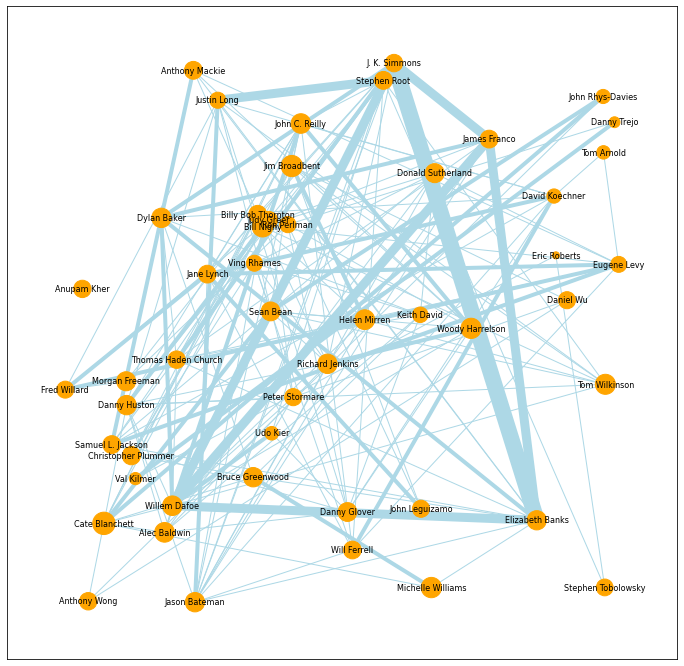

In [138]:
# Create a figure
plt.figure(figsize=(12,12))

# Get the node sizes
node_sizes = nx.get_node_attributes(G, 'size')

# Get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')  

# Get the actor names from the characters dataframe
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# Match the actor names to the node IDs
actor_names = {node: actor_names[node.split('_id_')[1]] for node in node_sizes}

# Position the nodes randomly
pos = nx.random_layout(G)

# Rescale the edge weights s.t. the smallest edge is 50 and the largest is 500
node_sizes = {node: node_sizes[node] for node in node_sizes}
node_sizes = {node: (node_sizes[node] - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values())) for node in node_sizes}
node_sizes = {node: 50 + 450 * node_sizes[node] for node in node_sizes}

# Draw the nodes with labels
nx.draw_networkx_nodes(G, pos=pos, node_size=[node_sizes[v] for v in G.nodes()], node_color='orange')

# Draw the edges
nx.draw_networkx_edges(G, pos=pos, edge_color='lightblue', width=[w**2 for _, _, w in G.edges(data='weight')])

# Draw the node labels
nx.draw_networkx_labels(G, pos=pos, labels=actor_names, font_size=8)

# Save the plot
plt.savefig('img/actor_network_num_movies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [139]:
# create a dictionary that maps actor IDs to actor names
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# create a new dictionary that maps the actor IDs in the movies_binary_actors10 dataframe to the actor names
labels = {'freebase_actor_ID_'+actor: actor_names[actor] for actor in actor_names}

# create a figure
plt.figure(figsize=(12,12))

# get the node sizes
node_sizes = nx.get_node_attributes(G, 'size')

# get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')  

# position the nodes randomly
pos = nx.random_layout(G, seed=3)

# for node in G.nodes():
#     plt.gca().add_artist(get_ab_from_actor(node, node_sizes, pos))

# # draw the graph
# nx.draw(G, pos=pos, with_labels=False, node_size=[node_sizes[v]/500000 for v in G.nodes()], edge_color='lightgreen', width=[w**2 for _, _, w in G.edges(data='weight')], node_color='lightblue')

# # save the plot
# # plt.savefig('actor_network.png', dpi=300, bbox_inches='tight')

# # show the plot
# plt.show()

<Figure size 864x864 with 0 Axes>

In [140]:
# # Perform community partitioning using Girvan-Newman method
# communities = list(nx.community.girvan_newman(G))

# # Get the number of communities
# num_communities = len(communities)

# # Print the number of communities
# print("The number of communities detected using Girvan-Newman method is:", num_communities)

In [141]:
# Detect communities in the graph through the Louvain method 
partition = community.best_partition(G, random_state=1, weight='weight') 

communities = {}

# Partition actors in communities
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        
# Get the number of communities
num_communities = len(communities)
        
print("The number of communities detected using Louvian method is:", num_communities)

The number of communities detected using Louvian method is: 7


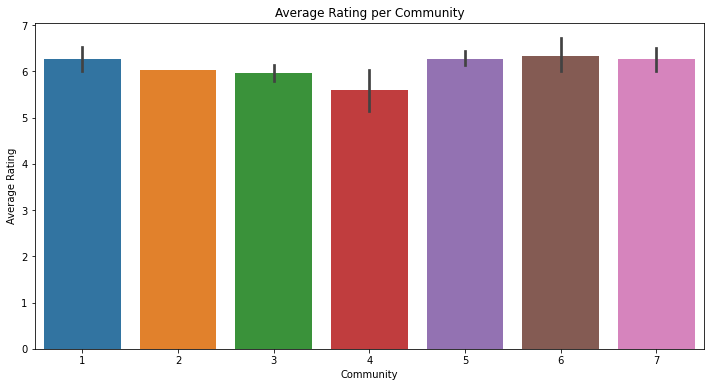

In [142]:
# Create a figure
plt.figure(figsize=(12,6))

# Create a Pandas dataframe from the dictionary
actors = pd.DataFrame.from_dict(partition.items(), orient='columns')

actors.columns = ['actor', 'community']

actors['averageRating'] = actors['actor'].apply(lambda x: node_sizes[x])

ax = sns.barplot(x="community", y="averageRating", data=actors)

plt.xlabel('Community')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks([x for x in range(7)], [x for x in range(1, 8)])

# Save the plot in the img folder
plt.savefig('img/community_rating_num_movies.png', dpi=300, bbox_inches='tight')
plt.show()

In [143]:
# ANOVA

# Create a list of average ratings for each community
community_ratings = [actors.loc[actors['community'] == i, 'averageRating'] for i in range(7)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*community_ratings)

# Output the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results based on the p-value
if p_value < 0.05:
    print("The difference in average rating across communities is statistically significant.")
else:
    print("There is no statistically significant difference in average rating across communities.")

F-statistic: 2.718249193040265
p-value: 0.025052313464406856
The difference in average rating across communities is statistically significant.


# Causal analysis of cast-diversity influence on movie rating

After having found a statistically significant difference in the average rating (of movies?) from different communities, we want to investigate another thematically similar question: Is it better to pick a all actors for a cast from within a community or should you rather pick actors across communities when you want to achieve a higher movie rating?
#### Method
For this analysis we first calculate the number of actors per community for each movie as well as the total count of considered actors. Afterwards, we calculate different measures for the diversity of the cast. For our continuos diversity indicators we then do a linear regression, while for our binary diversity indicator we first do paired matching and propensity score matching and then do a linear regression.

---
#### Results
* We didn't observe any statistically significant effect of the diversity on the movie rating.
* The diversity measure does not explain the variability in movie ratings. Viewers do not seem to care about how often the actors collaborate or how similar they are in terms of done movies, hence we conclude that they evaluate a movie based on other criteria.
---

### 1. Extend dataframe by diversity measures
While we have done the previous graphs based on actors, that have done at least 15 movies together for better visualizability, we will now continue with the 10-movie-threshold in order to keep enough samples and make statistically relevant statements. We therefore have to first rerun the community detection from the previous chapter.
#### 1.1 Recompute communities

In [144]:
actor_one_hot_choice = actor_one_hot_12

# Grouping movies so that each movie corresponds to a single row in the dataframe
movies_grouped_by_actor = actor_one_hot_choice.groupby("wikipedia_id").agg("sum")

# Merging the dummy actor columns with the movie data
movies_actors_one_hot = pd.merge(
    movies, movies_grouped_by_actor, left_on="wikipedia_id", right_index=True
)

# Create an empty graph
G = nx.Graph()

# Initialize dictionaries to store actor ratings and movies
actor_ratings = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies = {}   # Dictionary to store the movies each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot dataframe
for _, row in movies_actors_one_hot.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings[actor][0] += rating  # Update total ratings for this actor
            actor_ratings[actor][1] += 1  # Update movie count for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # Update node size
            actor_movies[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # Update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # Add a new edge with weight 1  

# Update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # Number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

# Get the number of edges
num_nodes = G.number_of_nodes()
# Print the number of edges
print("The number of nodes in the graph G is:", num_nodes)

# Get the number of edges
num_edges = G.number_of_edges()
# Print the number of edges
print("The number of edges in the graph G is:", num_edges)

# Detect communities in the graph through the Louvain method 
partition = community.best_partition(G, random_state=1, weight='weight') 

communities = {}

# Partition actors in communities
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        
# Get the number of communities
num_communities = len(communities)
        
print("The number of communities detected using Louvian method is:", num_communities)

The number of nodes in the graph G is: 178
The number of edges in the graph G is: 1420
The number of communities detected using Louvian method is: 11


#### 1.2 Extend dataset with community counts

* QUESTION: WHY DO WE HAVE MOVIES WITHOUT ACTORS WITHIN OUR MOVIES_ACTORS_10 DF? ( We loose super many movies for our analysis because of that) (see output of first and second code cells below)
* How to account for confounders for entropy and gini coefficient?

In [145]:
movies_one_hot_actors = actor_one_hot_choice.copy()
# Create a list of the column names of the actor columns
actor_columns = [col for col in movies_one_hot_actors.columns if col.startswith('freebase_actor_id_')]
movies_one_hot_actors['actor_count'] = movies_one_hot_actors[actor_columns].sum(axis=1)
print(f'#Movies without actors: {movies_one_hot_actors[movies_one_hot_actors["actor_count"] == 0].shape[0]}')
print("Examplary movies without actors")
display(movies_one_hot_actors[movies_one_hot_actors["actor_count"] == 0].head())


#Movies without actors: 59083
Examplary movies without actors


,wikipedia_id,freebase_actor_id_/m/012g92,freebase_actor_id_/m/012q4n,freebase_actor_id_/m/014gf8,freebase_actor_id_/m/014zcr,freebase_actor_id_/m/0151w_,freebase_actor_id_/m/0154qm,freebase_actor_id_/m/015rkw,freebase_actor_id_/m/015vq_,freebase_actor_id_/m/015wnl,...,freebase_actor_id_/m/0h32q,freebase_actor_id_/m/0h5g_,freebase_actor_id_/m/0jfx1,freebase_actor_id_/m/0kszw,freebase_actor_id_/m/0mdqp,freebase_actor_id_/m/0svqs,freebase_actor_id_/m/0ywqc,freebase_actor_id_/m/0z4s,freebase_actor_id_/m/0zcbl,actor_count
0,975900,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,975900,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,975900,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,975900,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,975900,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


First we create a new dataframe in which we include the number of actors per community as well as the total count of considered actors and the number of non-zero communities, per movie respectively.

In [146]:
# Base calculations on previously chosen one-hot-encoding dataframe
movies_one_hot_actors = actor_one_hot_choice.copy()
print(f'Movies considered:{len(movies_one_hot_actors["wikipedia_id"].unique())}')

# Get actor-community mapping in a list
flattened_data = [(actor, community_id) for community_id, actors in communities.items() for actor in actors]
#Convert this list into a DataFrame. This DataFrame will have two columns: one for actor IDs and one for community IDs.
actor_community = pd.DataFrame(flattened_data, columns=['actor_id', 'community_id'])

# Get actor-encoding column names for subsequent melting
actor_columns = [col for col in movies_one_hot_actors.columns if col.startswith('freebase_actor_id_')]

# Reshape one-hot-encoding from wide to long format
long_movies_df = movies_one_hot_actors.melt(id_vars=['wikipedia_id'], 
                                value_vars=actor_columns,
                                var_name='actor_id', 
                                value_name='is_present')

 # TODO In this step, we loose a lot of movies!!! Afterwards we only have 2213 movies leftis_present == 0)
# The only explanation for this is that we apparently have movies without actors...

# Filter out rows where the respective actor is not present
print(f'Number of movies before filtering for present actors: {len(long_movies_df["wikipedia_id"].unique())}')
long_movies_df = long_movies_df[long_movies_df['is_present'] == 1]
print(f'Number of movies after filtering for present actors: {len(long_movies_df["wikipedia_id"].unique())}')

# Include info about community per actor by merging with actor_community
merged_df = long_movies_df.merge(actor_community, on='actor_id')
# Remove the 'freebase_actor_id_' prefix from actor_id
merged_df['actor_id'] = merged_df['actor_id'].str.replace('freebase_actor_id_', '')

# Check if everything worked
# print(f'Unique actors after merge: {len(merged_df["actor_id"].unique())}')
# print(f'Unique communities after merge: {len(merged_df["community_id"].unique())}')

# Group by movie and community and count
community_counts = merged_df.groupby(['wikipedia_id', 'community_id']).size().reset_index(name='count')

# Pivot df such that each community count is entered in a separate column
pivoted_df = community_counts.pivot(index='wikipedia_id', columns='community_id', values='count')

# Resetting the index to turn wikipedia_id back into a column
pivoted_df.reset_index(inplace=True)

# Fill NaN values with 0 if there are movies without actors from certain communities
pivoted_df.fillna(0, inplace=True)

# Create a new column 'total_community_count' which is the sum of all community count columns
pivoted_df['total_community_count'] = pivoted_df[pivoted_df.columns[1:]].sum(axis=1)
# Create a new column 'non_zero_communities' which indicates the number communities with at least one actor
pivoted_df['non_zero_communities'] = pivoted_df[pivoted_df.columns[1:-1]].apply(lambda row: sum(x != 0 for x in row), axis=1)

# Rename columns for clarity
pivoted_df.columns = ['wikipedia_id'] + [f'community_{c}_count' for c in pivoted_df.columns[1:-2]] + ['total_community_count'] + ['non_zero_communities']

#Provide final dataframe
mov_com_count = pivoted_df.copy()

display(mov_com_count.head(1))
print(f'Final shape #movies x #columns: {mov_com_count.shape}')

Movies considered:6434
Number of movies before filtering for present actors: 6434
Number of movies after filtering for present actors: 1635


,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,total_community_count,non_zero_communities
0,11242,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,3


Final shape #movies x #columns: (1635, 14)


Let's have a look at the distribution of community counts across all movies and all communities.

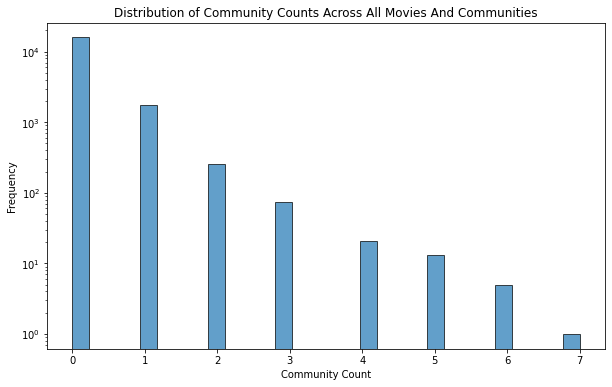

In [147]:
# Extract columns that start with 'community_' and end with '_count'
community_count_columns = [col for col in mov_com_count.columns if col.startswith('community_') and col.endswith('_count')]

# Flatten these columns into a single array
all_community_counts = mov_com_count[community_count_columns].values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_community_counts, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Community Counts Across All Movies And Communities')
plt.xlabel('Community Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


As seen above, the non-zero counts in the matrix are quite sparse, and the graph suggests an exponential relationship between the number of community members and their frequency. Most of the non-zero counts are ones, with only little movies having casts with several actors from the same community. This is - among other factors - due to the fact that we filtered out actors who haven't done at least 10 movies. Per community there are in general little actors left, as can be seen below.

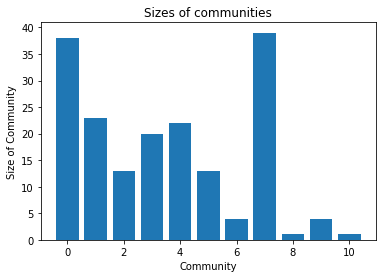

In [148]:
# Extracting the sizes of the communities
sizes = [len(arr) for arr in communities.values()]

# Plotting
plt.bar(communities.keys(), sizes)
plt.xlabel('Community')
plt.ylabel('Size of Community')
plt.title('Sizes of communities')
plt.show()

Yet, as seen below, each movie has at least one considered actor!

In [149]:
# Print amount of movies without considered actors
print(f'Number of movies that do not included any actor considered by us: {(mov_com_count["non_zero_communities"] == 0).sum()}')

Number of movies that do not included any actor considered by us: 0


#### 1.3. Calculating Cast Diversity Measures
Now that we have prepared our dataframes and got an idea of the data, we calculate different measures indicating how uniform a cast of a movie is in terms of their community. We calculate three different measures:
1. **Entropy:** Entropy in this context is a measure of diversity or unpredictability. For a cast of a movie, it can be used to quantify how evenly spread the cast members are across different communities. A lower entropy value would suggest that most cast members come from the same or a few communities (more uniform), while a higher value indicates a more diverse cast across many communities.
2. **Gini Coefficient:** Originally used to measure income inequality, the Gini coefficient can be adapted to measure inequality in community representation within a movie's cast. A Gini coefficient of 0 would indicate perfect uniformity (all cast members are from the same community), while a coefficient closer to 1 would indicate high inequality (cast members are evenly spread out across many communities).
3. **Binary Diversity Indicator:** If more than 70% of all considered actors come from the same community, we consider the cast as not being divers.

In [150]:
# Extract indexes of community columns
community_columns = [col for col in mov_com_count.columns if (col.startswith('community_') & col.endswith('count'))]
# Filter out unrepresentative movies with only 1 considered actor!
#mov_com_count = mov_com_count[(mov_com_count["total_community_count"] != 1)] TODO Include or not? If I don't the findings become statistically significant!
print (mov_com_count.shape)

(1635, 14)


##### 1.3.1 Entropy
Let's compute the first diversity indicator: Shannon Entropy. We use the following formula for the Shannon entropy:
$$ H(X) = -\sum_{i=1}^{n} P(x_i) \log_2 P(x_i) $$

Where:
- $H(X)$ is the entropy of the distribution of actors across communities in a movie.
- $n$  is the number of communities.
- $P(x_i)$ is the proportion of actors in the $i^{th}$ community relative to the total number of actors in the movie.


In [151]:
mov_entropy = mov_com_count.copy()

# Function to calculate entropy
def calculate_entropy(row):
    # Extracting community counts
    community_counts = row[community_columns].values

    # Calculating the total count to get proportions
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 0

    # Calculating proportions
    proportions = community_counts / total_count

    # Calculating entropy
    entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])  # Exclude zero proportions
    return entropy

# Applying the function to each row in the DataFrame
mov_entropy['entropy'] = mov_entropy.apply(calculate_entropy, axis=1)

display(mov_entropy.head(1))


,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,total_community_count,non_zero_communities,entropy
0,11242,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,3,1.370951


##### 1.3.2 Gini-Coefficient
Our second diversity indicator is the Gini coefficient. For a discrete probability distribution, the formula for the Gini coefficient can be simplified to:
$$ G = 1 - \sum_{i=1}^{n} P(x_i)^2 $$

Where:
- $G$ is the Gini coefficient.
- $n$ is the number of communities.
- $P(x_i)$ is the proportion of actors in the $i^{th}$ community relative to the total number of actors in the movie.

In [152]:
mov_gini = mov_entropy.copy()

import numpy as np
import pandas as pd

# Function to calculate the Gini coefficient
def calculate_gini(row):
    # Extracting community counts
    community_counts = row[community_columns].values
    
    # Calculating the total count to get proportions
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 0

    # Calculating proportions
    proportions = community_counts / total_count

    # Calculating Gini coefficient
    gini = 1 - np.sum(proportions ** 2)
    return gini

# Applying the function to each row in the DataFrame
mov_gini['gini_coefficient'] = mov_gini.apply(calculate_gini, axis=1)

display(mov_gini.head(1))

,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,total_community_count,non_zero_communities,entropy,gini_coefficient
0,11242,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,3,1.370951,0.56


##### 1.3.3 Binary Cast-Community Diversity Indicator

Finally we include the binary cast indicator. Our threshold is set to 0.7, meaning that whenever one represented community in a cast provides at least 70% o the actors we consider that cast to be not divers!

In [153]:
threshold = 0.7 # Set threshold here!
mov_bin_comdiv = mov_gini.copy()

# Returns 
def calculate_binary_community_diversity(row):
     # Extracting community counts
    community_counts = row[community_columns].values

    # Return 0 if no communities
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 1
    
    # Calculating proportions
    proportions = community_counts / total_count


    # Check for threshold and return 0 or one respectively
    # 0 == not divers, 1 == divers
    return 0 if max(proportions) >= threshold else 1

    
# Applying the function to each row in the DataFrame
mov_bin_comdiv['cast_is_community_divers'] = mov_bin_comdiv.apply(calculate_binary_community_diversity, axis=1)

display(mov_bin_comdiv.head(1))
print(f'#movies with divers cast: {mov_bin_comdiv["cast_is_community_divers"].sum()}')
print(f'#movies with non-divers cast: {(mov_bin_comdiv["cast_is_community_divers"] == 0).sum()}')

,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,total_community_count,non_zero_communities,entropy,gini_coefficient,cast_is_community_divers
0,11242,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,3,1.370951,0.56,1


#movies with divers cast: 374
#movies with non-divers cast: 1261


Let's examine the distribution of our newly calculated diversity measures.

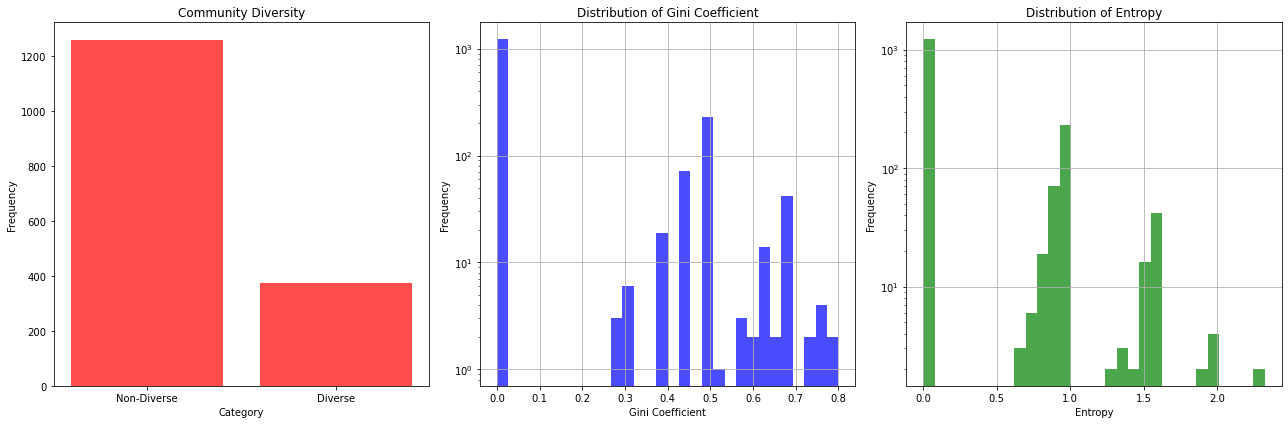

In [154]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting the distribution of the community diversity based upon threshold
values, counts = np.unique(mov_bin_comdiv['cast_is_community_divers'], return_counts=True)
axes[0].bar(['Non-Diverse', 'Diverse'], counts, color='red', alpha=0.7)
axes[0].set_title('Community Diversity')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Frequency')

# Plotting the distribution of the Gini Coefficient
axes[1].hist(mov_bin_comdiv['gini_coefficient'], bins=30, alpha=0.7, color='blue')
axes[1].set_title('Distribution of Gini Coefficient')
axes[1].set_xlabel('Gini Coefficient')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].grid(True)

# Plotting the distribution of Entropy
axes[2].hist(mov_bin_comdiv['entropy'], bins=30, alpha=0.7, color='green')
axes[2].set_title('Distribution of Entropy')
axes[2].set_xlabel('Entropy')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


As expected the diversity measures indicate a high uniformity across movies due to the fact that we often only consider one actor per movie.

### 2. Conduct Analysis Regarding Cast-Diversity

#### 2.1 Analysis using entropy and Gini coefficient as diversity measure
After all those preparation steps, let's finally look into how the diversity of a cast affects the movie ratings. We will start with the Gini coefficient and then continue with the entropy measure. But beforehand, let's import the necessary libraries and include the averageRating column.

In [155]:
# Import necessary libraries
import statsmodels.formula.api as smf
import ast
# Include necessary columns for matching and propensity-score calculation
original_movies = mov_bin_comdiv.merge(movies, on='wikipedia_id', how='left')
print(original_movies.columns)

Index(['wikipedia_id', 'community_0_count', 'community_1_count',
       'community_2_count', 'community_3_count', 'community_4_count',
       'community_5_count', 'community_6_count', 'community_7_count',
       'community_8_count', 'community_9_count', 'community_10_count',
       'total_community_count', 'non_zero_communities', 'entropy',
       'gini_coefficient', 'cast_is_community_divers', 'freebase_movie_id',
       'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries',
       'genres', 'year_release', 'averageRating', 'numVotes',
       'average_award_cumcount', 'average_movies_cumcount', 'award_cumcount',
       'movies_cumcount'],
      dtype='object')


Before conducting a regression, let's first look into how our data is distributed using scatterplots!

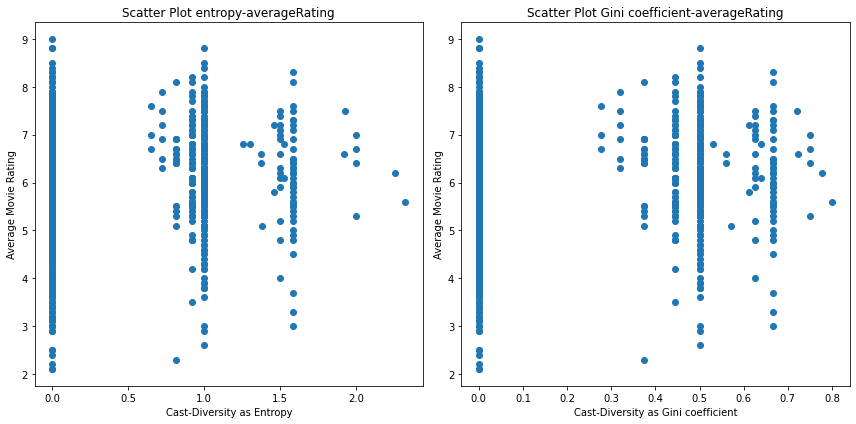

In [156]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(original_movies['entropy'], original_movies['averageRating'])
axes[0].set_xlabel('Cast-Diversity as Entropy')
axes[0].set_ylabel('Average Movie Rating')
axes[0].set_title('Scatter Plot entropy-averageRating')

axes[1].scatter(original_movies['gini_coefficient'], original_movies['averageRating'])
axes[1].set_xlabel('Cast-Diversity as Gini coefficient')
axes[1].set_ylabel('Average Movie Rating')
axes[1].set_title('Scatter Plot Gini coefficient-averageRating')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In the diagrams above no clear relationship between the diversity and the movie ratings is identifiable. We examine the relationship further using a linear regression.

In [157]:
# Conduct linear regression of entropy on averageRating
# Define formula
formula = 'averageRating ~ entropy'

# Initialize linear regression model
mod = smf.ols(formula=formula, data=original_movies)

# Fit the model
res = mod.fit()

# Print the results
print("Linear Regression Of Entropy On Average Movie Rating:")
print(res.summary())

Linear Regression Of Entropy On Average Movie Rating:
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.477
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0194
Time:                        18:15:36   Log-Likelihood:                -2392.3
No. Observations:                1635   AIC:                             4789.
Df Residuals:                    1633   BIC:                             4799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [158]:
# Conduct linear regression of Gini coefficient on averageRating
# Define formula
formula = 'averageRating ~ gini_coefficient'

# Initialize linear regression model
mod = smf.ols(formula=formula, data=original_movies)

# Fit the model
res = mod.fit()

# Print the results
print("Linear Regression Of Gini Coefficient On Average Movie Rating:")
print(res.summary())

Linear Regression Of Gini Coefficient On Average Movie Rating:
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.713
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0170
Time:                        18:15:36   Log-Likelihood:                -2392.2
No. Observations:                1635   AIC:                             4788.
Df Residuals:                    1633   BIC:                             4799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

When using the entropy and the gini coefficient we don't observe statistically significant covariates. Also for these models the R-squared values indicate, that these measures don't explain the rating variability. By plotting the samples using a scatter plot we try to identify a relationship between the diversity and the ratings. This can help in choosing the right regression model for our task. Yet, no clear relationship between the diversity and the rating can be identified. All in all, our results therefore indicate that there is no influence of the cast diversity on the movie rating.

### 2.2 Linear regression using binary diversity indicator
#### 2.2.1 Balance dataset by matching

Before we examine the effect that our binary diversity of a cast has on its rating, we have to account for potential confounders. For our binary diversity indicator, we can therefore do paired-matching and match additionally based on the propensity score.
First, we calculate the propensity score including the following standardized variables:
* number of languages
* number of targeted countries
* release year
* runtime

In [159]:
# convert all dicts in string form to actual dictionaries
original_movies['languages'] = original_movies['languages'].apply(ast.literal_eval)
original_movies['countries'] = original_movies['countries'].apply(ast.literal_eval)
original_movies['genres'] = original_movies['genres'].apply(ast.literal_eval)

# Calculate relevant variables for propensity score
original_movies['num_languages'] = original_movies['languages'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
original_movies['num_countries'] = original_movies['countries'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

# Standardize
original_movies['year_release'] = (original_movies['year_release'] - original_movies['year_release'].mean())/original_movies['year_release'].std()
original_movies['num_languages'] = (original_movies['num_languages'] - original_movies['num_languages'].mean())/original_movies['num_languages'].std()
original_movies['num_countries'] = (original_movies['num_countries'] - original_movies['num_countries'].mean())/original_movies['num_countries'].std()
#original_movies['budget'] = (original_movies['budget'] - original_movies['budget'].mean())/original_movies['budget'].std() TODO include budget

# compute propensity score
formula = 'cast_is_community_divers ~  year_release + num_languages + num_countries'

# initialize the model
mod = smf.logit(formula=formula, data=original_movies)

# fit the model
res = mod.fit()

# add propensity score to the dataframe
original_movies['propensity_score'] = res.predict(original_movies[['year_release', 'num_languages', 'num_countries']])

# print the results
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.530759
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     cast_is_community_divers   No. Observations:                 1635
Model:                                Logit   Df Residuals:                     1631
Method:                                 MLE   Df Model:                            3
Date:                      Fri, 22 Dec 2023   Pseudo R-squ.:                 0.01301
Time:                              18:15:37   Log-Likelihood:                -867.79
converged:                             True   LL-Null:                       -879.23
Covariance Type:                  nonrobust   LLR p-value:                 4.270e-05
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2325      0.060    -20.646      0.

Now we can match based on the similarity of certain attributes and the previously calculated propensity score.
To ensure a certain similarity, we only match samples with a difference in the propensity scores below 0.05. Additionally we do paired-matching on the following facts:
* movies should share at least a genre
* movies should share at least a language
* movies should share at least a targeted country

In [160]:
# Declare helper function to be used for paired-matching
from typing import Dict
def shared_value(dict1: Dict, dict2: Dict, min_shared_threshold: int = 1) -> bool:
    """
    Determine if two dictionaries share a certain number of values.

    Args:
    dict1 (Dict): First dictionary.
    dict2 (Dict): Second dictionary.
    min_shared_threshold (int): Minimum number of shared values required.

    Returns:
    bool: True if the dictionaries share at least `min_shared_threshold` values, False otherwise.
    """
    shared_values = set(dict1.values()) & set(dict2.values())
    return len(shared_values) >= min_shared_threshold

In [161]:
# try matching with requirement on genre and similarity
treatment = original_movies[original_movies['cast_is_community_divers'] == 1]
control = original_movies[original_movies['cast_is_community_divers'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treatment.iterrows():

        # Calculate difference
        difference = np.abs(control_row['propensity_score'] - treatment_row['propensity_score'])
        
        
        # Only include samples with similar propensity scores and other shared values
        if shared_value(control_row['genres'], treatment_row['genres'], min_shared_threshold=1) \
            and shared_value(control_row['languages'], treatment_row['languages'], min_shared_threshold=1) \
            and shared_value(control_row['countries'], treatment_row['countries'], min_shared_threshold=1) \
            and difference < 0.05:
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, difference)])

# Generate the maximum weight matching on the generated graph
min_weight_matching = nx.min_weight_matching(G)

# collect matched instances
matched_movies = [i[0] for i in list(min_weight_matching)] + [i[1] for i in list(min_weight_matching)]

# create the balanced dataset
balanced_movie_df = original_movies.iloc[matched_movies].copy()
print("Number of movies in balanced dataframe: ", balanced_movie_df.shape[0])


Number of movies in balanced dataframe:  716


#### 2.2.2 Linear regression

Now that we balanced our dataset by accounting for potential confounders, we can analyse the effect that the diversity of a cast indicated by our binary measure has on the ratings.
Very important to notice here though is, that our balanced dataset only includes 142 movies. Hence any result can merely provide a hint on what might be true, as the number of movies is too small to provide statistical significance.

First, let's examine the difference in average movie ratings between our balanced and unbalanced datasets as well as between divers and non-divers casts

In [162]:
print(
    f'''
    Unbalanced Dataset:
    Avg. movie rating of divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 1]["averageRating"].mean()}
    Avg. movie rating of non-divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 0]["averageRating"].mean()}
    
    Balanced Dataset:
    Avg. movie rating of divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 1]["averageRating"].mean()}
    Avg. movie rating of non-divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 0]["averageRating"].mean()}
    '''
)


    Unbalanced Dataset:
    Avg. movie rating of divers movie casts: 6.192513368983957
    Avg. movie rating of non-divers movie casts: 6.056621728786677
    
    Balanced Dataset:
    Avg. movie rating of divers movie casts: 6.192513368983957
    Avg. movie rating of non-divers movie casts: 6.056621728786677
    


Now, let's analyse the impact using linear regression. We will compare results using our balanced and unbalanced dataset.

Regression analysis results using UNBALANCED dataset
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.868
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0275
Time:                        18:17:04   Log-Likelihood:                -2392.6
No. Observations:                1635   AIC:                             4789.
Df Residuals:                    1633   BIC:                             4800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

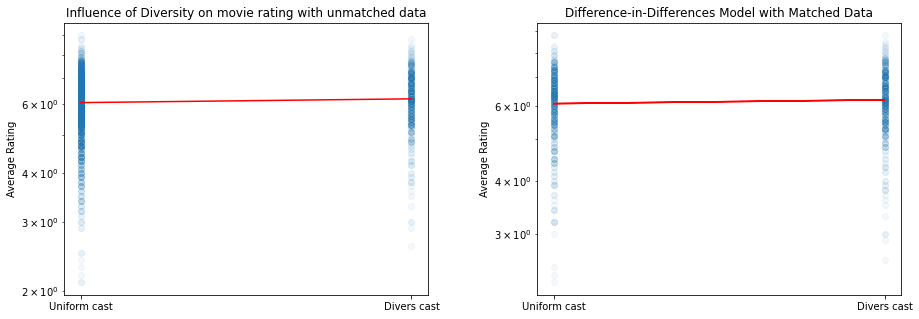

In [163]:
# Declare and fit the model with unbalanced data
print("Regression analysis results using UNBALANCED dataset")
naive_model = smf.ols(formula="averageRating ~ cast_is_community_divers", data=original_movies)
naive_res = naive_model.fit()
print(naive_res.summary())

# Declare and fit the model with balanced data
print("Regression analysis results using BALANCED dataset")
matched_model = smf.ols(formula="averageRating ~ cast_is_community_divers", data=balanced_movie_df)
matched_res = matched_model.fit()
print(matched_res.summary())

# Print the coefficients and p-values
print(
    f'''
    Coefficient for the treatment without matching:     {round(naive_res.params['cast_is_community_divers'], 3)}
    Coefficient for the treatment with matching:         {round(matched_res.params['cast_is_community_divers'], 3)}
    Difference in percent:                                 {round((matched_res.params['cast_is_community_divers'] - naive_res.params['cast_is_community_divers'])/naive_res.params['cast_is_community_divers']*100, 2)}%
    
    p-value for the treatment without matching:          {round(naive_res.pvalues['cast_is_community_divers'], 3)}
    p-value for the treatment with matching:             {round(matched_res.pvalues['cast_is_community_divers'], 3)}
    '''
)
# plot the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the models
# Style plot based on unmatched data
axs[0].scatter(original_movies['cast_is_community_divers'], original_movies['averageRating'], alpha=0.05)
axs[0].plot(original_movies['cast_is_community_divers'], naive_res.fittedvalues, color='red')
axs[0].set_yscale('log')
axs[0].set_title('Influence of Diversity on movie rating with unmatched data')
axs[0].set_ylabel('Average Rating')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Uniform cast', 'Divers cast'])

# Style plot based on matched data 
axs[1].scatter(balanced_movie_df['cast_is_community_divers'], balanced_movie_df['averageRating'], alpha=0.05)
axs[1].plot(balanced_movie_df['cast_is_community_divers'], matched_res.fittedvalues, color='red')
axs[1].set_yscale('log')
axs[1].set_title('Difference-in-Differences Model with Matched Data')
axs[1].set_ylabel('Average Rating')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Uniform cast', 'Divers cast'])

# Separate the plots using whitespace
plt.subplots_adjust(wspace=0.3)

plt.savefig('img/evenly_vs_majority.png')

# show the plot
plt.show()

The found coefficients are not statistically significant and additionally the R-squared value is extremely low, meaning that both our unmatched and matched model do not explain the variability in the ratings.

## Network Graph: Age Gap among Actors or Not ?

In [164]:
# Filter the characters dataframe to only include the actors that are also found in the movies_actors_one_hot dataframe

# Get the column names from the movies_actors_one_hot dataframe
column_names = movies_actors_one_hot.columns

# Prepend 'freebase_actor_id_' to each value in the 'freebase_actor_id' column
modified_ids = 'freebase_actor_id_' + characters['freebase_actor_id'].astype(str)

# Filter the dataframe using the modified IDs
actors_in_movies = characters[modified_ids.isin(column_names)]

# Remove the actors that do not have an actor_age_at_release value in the characters dataframe
actors_in_movies = actors_in_movies[actors_in_movies['actor_age_at_release'].notna()]

# Filter the movies_actors_one_hot dataframe to only include the actors that have an actor_age_at_release value
movies_actors_one_hot_age = movies_actors_one_hot[movies_actors_one_hot['wikipedia_id'].isin(actors_in_movies['wikipedia_movie_id'])]

movies_actors_one_hot_age.shape

(1607, 194)

In [165]:
# Create a new graph for actor connections based on age difference
G_age = nx.Graph()

# Initialize dictionaries to store actor ratings and movie information
actor_ratings_age = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies_age = {}   # Dictionary to store the movies that each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot_age dataframe
for _, row in movies_actors_one_hot_age.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings_age:
            actor_ratings_age[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G_age.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies_age[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings_age[actor][0] += rating  # Update total ratings for this actor
            actor_ratings_age[actor][1] += 1  # Update movie count for this actor
            G_age.nodes[actor]['size'] = actor_ratings_age[actor][0] / actor_ratings_age[actor][1]  # Update node size
            actor_movies_age[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Create edges between actors who have appeared in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            
            # Create modified actor IDs for comparison
            modified_ids = 'freebase_actor_id_' + actors_in_movies['freebase_actor_id'].astype(str)

            filtered_df = actors_in_movies[(modified_ids == actor1) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]
            if not filtered_df.empty:
                age_actor1 = filtered_df['actor_age_at_release'].iloc[0]
            else:
                print("Empty line found actor 1!")
                continue  # Or any other appropriate action

            filtered_df = actors_in_movies[(modified_ids == actor2) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]
            if not filtered_df.empty:
                age_actor1 = filtered_df['actor_age_at_release'].iloc[0]
            else:
                print("Empty line found actor 2!")
                continue  # Or any other appropriate action
            
            # Retrieve age of actor1 and actor2 in the current movie
            age_actor1 = actors_in_movies[(modified_ids == actor1) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]['actor_age_at_release'].iloc[0]
            age_actor2 = actors_in_movies[(modified_ids == actor2) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]['actor_age_at_release'].iloc[0]

            # Ensure the ages are floats
            age_actor1 = float(age_actor1)
            age_actor2 = float(age_actor2)

            # Calculate age difference
            age_diff = abs(age_actor1 - age_actor2)
            if age_diff == 0.0:
                age_diff = 1.0
            
            # Rescale age difference to be between 1 and 2 
            age_diff = (1 / age_diff) + 1

            if not G_age.has_edge(actor1, actor2):
                # Add a new edge with weight equal to age difference
                G_age.add_edge(actor1, actor2, weight=age_diff)


Empty line found actor 2!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 2!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 2!
Empty line found actor 2!
Empty line found actor 1!
Empty line found actor 2!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 1!
Empty line found actor 2!
Empty line found actor 1!
Empty line found actor 1!


In [166]:
# Get the number of edges
num_nodes_age = G_age.number_of_nodes()
# Print the number of edges
print("The number of nodes in the graph G is:", num_nodes_age)

# Get the number of edges
num_nodes_age = G_age.number_of_edges()
# Print the number of edges
print("The number of edges in the graph G is:", num_nodes_age)

The number of nodes in the graph G is: 178
The number of edges in the graph G is: 1393


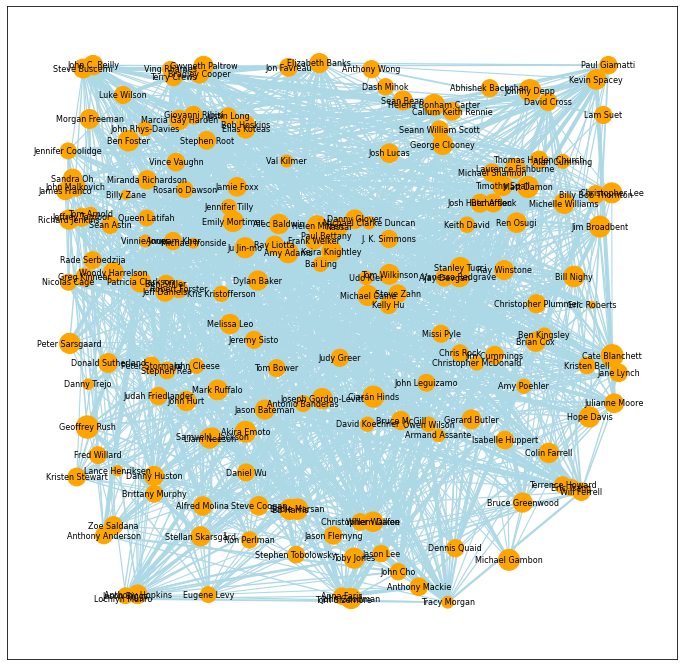

In [167]:
# Create a figure
plt.figure(figsize=(12,12))

# Get the node sizes
node_sizes = nx.get_node_attributes(G_age, 'size')

# Get the edge weights
edge_weights = nx.get_edge_attributes(G_age, 'weight')  

# Get the actor names from the characters dataframe
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# Match the actor names to the node IDs
actor_names = {node: actor_names[node.split('_id_')[1]] for node in node_sizes}

# Position the nodes randomly
pos = nx.random_layout(G_age)

# Rescale the edge weights s.t. the smallest edge is 50 and the largest is 500
node_sizes = {node: node_sizes[node] for node in node_sizes}
node_sizes = {node: (node_sizes[node] - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values())) for node in node_sizes}
node_sizes = {node: 50 + 450 * node_sizes[node] for node in node_sizes}

# Draw the nodes with labels
nx.draw_networkx_nodes(G_age, pos=pos, node_size=[node_sizes[v] for v in G_age.nodes()], node_color='orange')

# Draw the edges
nx.draw_networkx_edges(G_age, pos=pos, edge_color='lightblue', width=[w**2 for _, _, w in G_age.edges(data='weight')])

# Draw the node labels
nx.draw_networkx_labels(G_age, pos=pos, labels=actor_names, font_size=8)

# Save the plot
plt.savefig('img/actor_network_age.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [168]:
# Use the Louvain method to detect communities in the graph
partition_age = community.best_partition(G_age, random_state=1, weight='weight')

communities_age = {}

# Print the actors in each community
for actor, community_id in partition_age.items():
    if community_id not in communities_age:
        communities_age[community_id] = [actor]
    else:
        communities_age[community_id].append(actor)
        
print(len(communities_age))


11


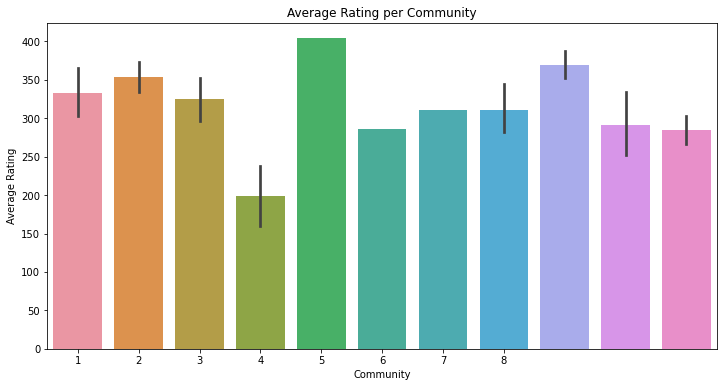

In [169]:
# Create a figure
plt.figure(figsize=(12,6))

# Create a Pandas dataframe from the dictionary
actors = pd.DataFrame.from_dict(partition_age.items(), orient='columns')

actors.columns = ['actor', 'community']

actors['averageRating'] = actors['actor'].apply(lambda x: node_sizes[x])

ax = sns.barplot(x="community", y="averageRating", data=actors)

plt.xlabel('Community')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks([x for x in range(8)], [x for x in range(1, 9)])

plt.savefig('img/community_rating_age.png', dpi=300, bbox_inches='tight')
plt.show()

In [170]:
# ANOVA

# Create a list of average ratings for each community
community_ratings = [actors.loc[actors['community'] == i, 'averageRating'] for i in range(8)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*community_ratings)

# Output the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results based on the p-value
if p_value < 0.05:
    print("The difference in average rating across communities is statistically significant.")
else:
    print("There is no statistically significant difference in average rating across communities.")

F-statistic: 8.898574309967174
p-value: 3.7044049902016956e-08
The difference in average rating across communities is statistically significant.
